In [22]:
import numpy as np 
import pandas as pd 

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from tpot import TPOTRegressor
import h2o
from h2o.sklearn import H2OAutoMLRegressor

import warnings
warnings.filterwarnings("ignore")

https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/overview

In [23]:
train = pd.read_csv("train.csv")
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis (EDA)

In [24]:
train.shape

(4209, 378)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [26]:
train.isnull().sum()

ID      0
y       0
X0      0
X1      0
X2      0
       ..
X380    0
X382    0
X383    0
X384    0
X385    0
Length: 378, dtype: int64

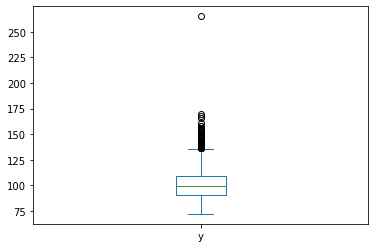

In [27]:
train['y'].plot.box();

In [28]:
Q1 = train['y'].quantile(0.25)
Q3 = train['y'].quantile(0.75)

IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

print(lower_whisker)
print(upper_whisker)

63.534999999999975
136.29500000000002


In [29]:
outlier_index = train[(train.y > upper_whisker)].index
outlier_index

Int64Index([  43,  203,  216,  253,  342,  420,  429,  681,  846,  883,  889,
             900,  995,  998, 1033, 1036, 1060, 1141, 1203, 1205, 1269, 1279,
            1349, 1459, 1730, 2240, 2263, 2348, 2357, 2376, 2414, 2470, 2496,
            2735, 2736, 2852, 2887, 2888, 2905, 2983, 3028, 3090, 3133, 3177,
            3215, 3442, 3744, 3773, 3980, 4176],
           dtype='int64')

In [30]:
train = train.drop(outlier_index)

y = train['y']
X = train.drop(['y','ID'], axis = 1)

numerical_features = X.select_dtypes(include = 'number').columns.values
categorical_features = X.select_dtypes(exclude = 'number').columns.values

# Baseline

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

numerical_transformer = Pipeline(steps=[ ("imputer", SimpleImputer(strategy='median')),
                                        ("scaler", StandardScaler()),
                                        ("fs", SelectKBest(score_func=mutual_info_regression, k=30)), ])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)), 
    ("scaler", StandardScaler()), ])

data_transformer = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, numerical_features), 
    ("categorical", categorical_transformer, categorical_features), 
])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

regressor_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("regressor",  LinearRegression())])

In [32]:
regressor_pipeline.fit(X_train, y_train)
preds_lr = regressor_pipeline.predict(X_val)
print(r2_score(y_val, preds_lr))

0.6285827248510509


# TPOT

In [16]:
oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

oe.fit(X_train[categorical_features])
X_train[categorical_features] = oe.transform(X_train[categorical_features])
X_val[categorical_features] = oe.transform(X_val[categorical_features])

In [17]:
impute = SimpleImputer(strategy='median')

impute.fit(X_train)
X_train = impute.transform(X_train)
X_val = impute.transform(X_val)

In [18]:
tpot = TPOTRegressor(generations=3, 
                     population_size=20, 
                     verbosity=2, 
                     random_state=42, 
                     n_jobs=-1)

tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/80 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -46.7040807484553

Generation 2 - Current best internal CV score: -46.7040807484553

Generation 3 - Current best internal CV score: -46.66573969161217

Best pipeline: DecisionTreeRegressor(OneHotEncoder(CombineDFs(input_matrix, input_matrix), minimum_fraction=0.1, sparse=False, threshold=10), max_depth=4, min_samples_leaf=14, min_samples_split=6)


TPOTRegressor(generations=3, n_jobs=-1, population_size=20, random_state=42,
              verbosity=2)

In [19]:
preds_tpot = tpot.predict(X_val)
print(r2_score(y_val, preds_tpot))

0.6364601466156122


# H2O

In [33]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 07 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_Пользователь_0qv6rn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.963 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [34]:
h2o = H2OAutoMLRegressor(max_models=10, seed=42)
h2o.fit(X_train, y_train.values)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
07:11:56.69: AutoML: XGBoost is not available; skipping it.
07:11:56.205: _train param, Dropping bad and constant columns: [X107, X339, X297, X330, X233, X93, X289, X235, X268, X347, X11, X290, X270, X293]

███
07:12:07.156: _train param, Dropping bad and constant columns: [X107, X339, X297, X330, X233, X93, X289, X235, X268, X347, X11, X290, X270, X293]

███
07:12:24.885: _train param, Dropping bad and constant columns: [X107, X339, X297, X330, X233, X93, X289, X235, X268, X347, X11, X290, X270, X293]

████
07:13:59.407: _train param, Dropping bad and constant columns: [X107, X339, X297, X330, X233, X93, X289, X235, X268, X347, X11, X290, X270, X293]
07:14:11.592: _train param, Dropping bad and constant columns: [X107, X339, X297, X330, X233, X93, X289, X235, X268, X347, X11, X2

H2OAutoMLRegressor(max_models=10, seed=42)

In [35]:
preds_h2o = h2o.predict(X_val)
print(r2_score(y_val, preds_h2o))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
0.6320008916955249


In [36]:
print('Сoefficient of determination R2: ')
print(f" - Linear Regressor = {round(r2_score(y_val, preds_lr),4)}")
print(f" - TPOT Regressor = {round(r2_score(y_val, preds_tpot),4)}")
print(f" - H2O Regressor = {round(r2_score(y_val, preds_h2o),4)}")

Сoefficient of determination R2: 
 - Linear Regressor = 0.6286
 - TPOT Regressor = 0.6365
 - H2O Regressor = 0.632


#### The best value of the determination coefficient is obtained using the TPOT Regressor